<a href="https://colab.research.google.com/github/carolynw898/STAT946Proj/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import torch

n_embd = 512
timesteps = 1000
batch_size = 256
learning_rate = 1e-4
num_epochs = 5
blockSize = 200
testBlockSize = 400
numVars = 3
numYs = 1
numPoints = 500
target = 'Skeleton'
const_range = [-2.1, 2.1] # constant range to generate during training only if target is Skeleton
decimals = 8 # decimals of the points only if target is Skeleton
trainRange = [-3.0,3.0] # support range to generate during training only if target is Skeleton
addVars = False
maxNumFiles = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
dataDir = "/content/drive/MyDrive/Colab/STAT946_proj/data"
dataFolder = "3_var_dataset"

In [15]:
from torch.utils.data import DataLoader
import numpy as np
import glob
from utils import processDataFiles, CharDataset, tokenize_equation
import random
import json

path = '{}/{}/Train/*.json'.format(dataDir, dataFolder)
files = glob.glob(path)[:maxNumFiles]
text = processDataFiles(files)
text = text.split('\n') # convert the raw text to a set of examples
# skeletons = []
skeletons = [json.loads(item)['Skeleton'] for item in text if item.strip()]
all_tokens = set()
for eq in skeletons:
    all_tokens.update(tokenize_equation(eq))
integers = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}
all_tokens.update(integers)  # add all integers to the token set
tokens = sorted(list(all_tokens) + ['_', 'T', '<', '>', ':'])  # special tokens
trainText = text[:-1] if len(text[-1]) == 0 else text
random.shuffle(trainText) # shuffle the dataset, it's important specailly for the combined number of variables experiment

In [16]:
train_dataset = CharDataset(trainText, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

idx = np.random.randint(train_dataset.__len__())
inputs, outputs, points, variables = train_dataset.__getitem__(idx)
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

data has 498101 examples, 30 unique.
id:490979
outputs:C*x1+C*x3+C>______________________________________________________
variables:3


In [17]:
path = '{}/{}/Test/*.json'.format(dataDir,dataFolder)
files = glob.glob(path)
textTest = processDataFiles([files[0]])
textTest = textTest.split('\n') # convert the raw text to a set of examples
test_dataset = CharDataset(textTest, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

# print a random sample
idx = np.random.randint(test_dataset.__len__())
inputs, outputs, points, variables = test_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        num_workers=2
    )

data has 926 examples, 30 unique.
tensor(-3.7178) tensor(2.9917)
id:68
outputs:C*cos(C*x2)+C*cos(C*x3+C)+C>__________________________________________
variables:3


In [18]:
import torch
import json
from scipy.optimize import minimize
from math import log
import math
from utils import relativeErr, lossFunc
import numpy as np
from sympy import sympify, Symbol, sin, cos, log, exp


def validate_prediction(
    skeleton, variables=["x1", "x2", "x3", "x4", "x5"], constant_symbol="C"
):
    local_dict = {var: Symbol(var) for var in variables}
    local_dict[constant_symbol] = Symbol(constant_symbol)

    local_dict.update(
        {
            "sin": sin,
            "cos": cos,
            "log": log,
            "exp": exp,
        }
    )

    try:
        expr = sympify(
            skeleton, locals=local_dict, evaluate=False, convert_xor=True
        )
    except Exception as e:
        return False

    return True

SAFE_GLOBALS = {
    'sin': math.sin,
    'cos': math.cos,
    'tan': math.tan,
    'log': math.log,
    'exp': math.exp,
    'sqrt': math.sqrt,
    'abs': abs,
    'pow': pow,
    '__builtins__': {}
}

@torch.no_grad()
def test_model(model, test_loader, textTest, train_dataset, device):
    results = {"target": [], "target_skeleton": [], "predicted_skeleton": [], "predicted": [], "error": []}
    for batch_idx, (_, tokens, points, variables) in enumerate(test_loader):
        points = points.to(device)
        tokens = tokens.to(device)
        variables = variables.to(device)
        B = points.shape[0]
        predicted_skeletons = model.sample(points, variables, train_dataset, B)

        for i in range(B):
            t = json.loads(textTest[batch_idx * test_loader.batch_size + i])
            eq = t["EQ"]

            eq_skeleton = ''.join([train_dataset.itos[int(i)] for i in tokens[0]])
            eq_skeleton = eq_skeleton.strip(train_dataset.paddingToken).split('>')
            eq_skeleton = eq_skeleton[0] #if len(eq[0])>=1 else eq[1]
            eq_skeleton = eq_skeleton.strip('<').strip(">")

            # Predicted
            predicted_skeleton = predicted_skeletons[i]
            predicted = predicted_skeleton

            #if not validate_prediction(predicted_skeleton):
            #    continue

            # Fit constants
            c = [1.0 for i,x in enumerate(predicted) if x=='C'] # initialize coefficients as 1
            # c[-1] = 0 # initialize the constant as zero
            b = [(-2,2) for i,x in enumerate(predicted) if x=='C']  # bounds on variables
            try:
                if len(c) != 0:
                    # This is the bottleneck in our algorithm
                    # for easier comparison, we are using minimize package
                    cHat = minimize(lossFunc, c, #bounds=b,
                                args=(predicted, t['X'], t['Y']))

                    predicted = predicted.replace('C','{}').format(*cHat.x)
            except ValueError:
                continue
                raise 'Err: Wrong Equation {}'.format(predicted)
            except Exception as e:
                continue
                raise 'Err: Wrong Equation {}, Err: {}'.format(predicted, e)

            Ys = [] #t['YT']
            Yhats = []
            for xs in t['XT']:
                try:
                    eqTmp = eq + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                             raise ValueError('There is a , in the equation!')
                    YEval = eval(eqTmp, SAFE_GLOBALS)
                    YEval = 0 if np.isnan(YEval) else YEval
                    YEval = 100 if np.isinf(YEval) else YEval
                except:
                    #print('TA: For some reason, we used the default value. Eq:{}'.format(eqTmp))
                    #print(i)
                    #raise
                    continue # if there is any point in the target equation that has any problem, ignore it
                    YEval = 100 #TODO: Maybe I have to punish the model for each wrong template not for each point
                Ys.append(YEval)
                try:
                    eqTmp = predicted + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                            assert 'There is a , in the equation!'
                    Yhat = eval(eqTmp, SAFE_GLOBALS)
                    Yhat = 0 if np.isnan(Yhat) else Yhat
                    Yhat = 100 if np.isinf(Yhat) else Yhat
                except:
                    #print('PR: For some reason, we used the default value. Eq:{}'.format(eqTmp))
                    Yhat = 100
                Yhats.append(Yhat)

            # Compute error and store results
            err = relativeErr(Ys,Yhats, info=True)

            if type(err) is np.complex128 or type(err) is complex: # replace np.complex with complex
                err = abs(err.real)

            best_err = 1000000
            best_pred = 'C'
            if err < best_err:
                best_err = err
                best_pred = predicted

            print(f'\nTarget: {eq}')
            print(f'Predicted: {best_pred}')
            print('Err:{}'.format(best_err))
            print('-'*10)

            # Compute error and store results
            err = relativeErr(Ys, Yhats, info=True)
            results["target"].append(eq)
            results["target_skeleton"].append(eq_skeleton)
            results["predicted_skeleton"].append(predicted_skeleton)
            results["predicted"].append(best_pred)
            results["error"].append(best_err)

    return results


In [19]:
import matplotlib.pyplot as plt

def plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey='DiffuSym'):
    if isinstance(resultDict, dict):
        num_eqns = len(resultDict[fName][modelKey]['err'])
        num_vars = pconf.numberofVars
        title = titleTemplate.format(num_eqns, num_vars)

        models = list(key for key in resultDict[fName].keys() if len(resultDict[fName][key]['err'])==num_eqns)
        lists_of_error_scores = [resultDict[fName][key]['err'] for key in models if len(resultDict[fName][key]['err'])==num_eqns]
        linestyles = ["-","dashdot","dotted","--"]

        eps = 0.00001
        y, x, _ = plt.hist([np.log([max(min(x+eps, 1e5),1e-5) for x in e]) for e in lists_of_error_scores],
                        label=models,
                        cumulative=True,
                        histtype="step",
                        bins=2000,
                        density=True,
                        log=False)
        y = np.expand_dims(y,0)
        plt.figure(figsize=(15, 10))

        for idx, m in enumerate(models):
            plt.plot(x[:-1],
                y[idx] * 100,
                linestyle=linestyles[idx],
                label=m)

        plt.legend(loc="upper left")
        plt.title(title)
        plt.xlabel("Log of Relative Mean Square Error")
        plt.ylabel("Normalized Cumulative Frequency")

        name = '{}.png'.format(fName.split('.txt')[0])
        plt.savefig(name)

        with open(fName, 'w', encoding="utf-8") as o:
            for i in range(num_eqns):
                err = resultDict[fName][modelKey]['err'][i]
                eq = resultDict[fName][modelKey]['trg'][i]
                predicted = resultDict[fName][modelKey]['prd'][i]
                print('Test Case {}.'.format(i))
                print('Target:{}\nSkeleton:{}'.format(eq, predicted))
                print('Err:{}'.format(err))
                print('') # just an empty line


                o.write('Test Case {}/{}.\n'.format(i,len(textTest)-1))

                o.write('{}\n'.format(eq))
                o.write('{}:\n'.format(modelKey))
                o.write('{}\n'.format(predicted))

                o.write('{}\n{}\n\n'.format(
                                        predicted,
                                        err
                                        ))

                print('Avg Err:{}'.format(np.mean(resultDict[fName][modelKey]['err'])))

def run_and_plot(model, fName, test_loader, textTest, train_dataset, device, pconf=None):
    """
    Run test_model and format results for plot_and_save_results, ensuring one figure.
    """

    results = test_model(model, test_loader, textTest, train_dataset, device)

    modelKey = 'DiffuSym'
    resultDict = {
        fName: {
            modelKey: {
                'err': results['error'],
                'trg': results['target'],
                'prd': results['predicted']
            }
        }
    }

    plt.figure(figsize=(15, 10))
    titleTemplate = "{} equations of {} variables - Benchmark"
    plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey=modelKey)
    plt.close()


Target: -1.5982388017817581*x1*x2+-2.044318899637824*x2+-1.7746907028515462*exp(0.7039673314731902*x1)*-0.8668809182829045*exp(0.3777536736420375*x2)+-2.0127950458697312
Predicted: 0.11695072982126958*x1**2+0.19049972976632001
Err:2.594010608897465
----------

Target: 1.7016581024952169*x1*0.23727959985542935*log(0.36487304775466267*x2+0.03292925562520255)+0.8705746155666412
Predicted: 0.19436283023578357*0.19436283023578357
Err:0.06349177013205712
----------

Target: -1.9634546414883929*x1+1.372145030809131*x2+0.6300532975162816*x3+-0.15792781214722296
Predicted: 0.076179841681611*x3+0.022638914731749015
Err:0.4451917520210689
----------

Target: -1.3703910882472434*x1*1.4647749513023895*exp(0.12560772352840655*x1)+0.7557286094378872*x2+-0.8589910065971147*sin(1.8033259915159126*log(1.785321179525333*x3+1.8622201122474968))+1.9127313883342612
Predicted: 0.05030662656064339*x3+0.2674392959662298
Err:0.6843331894841657
----------

Target: 0.8325644822370037*log(-0.49563160457437694*x2+

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.1810734332006327*x1+1.9991478340355582*x3/(-0.6870350016623634*x3)+-0.02604404169394714/(-1.4251214493157884*x3*1.289257265912175*sin(0.2493983548178602*x1+-0.12031587858484971)**3+-0.41004184917811326*sin(0.06576950485560484*x1+0.9869822633388412)**3)+-1.5100769814690689
Predicted: 1.0*1.0(1.0*x3)+1.0
Err:75.20083366250897
----------

Target: 1.9320849816085084*x3**4+-1.1451302454476318*x3**3+1.2130538509601796*x3**2+0.9174318183151366*x3+0.8347891880462699
Predicted: 1.753350202688651*x3**4+0.22826185031359075
Err:0.0009240342290676003
----------

Target: 1.0602195875583798/x1+-0.12479489636054453
Predicted: -0.4891766906489327+x1
Err:2.1153404711803376
----------

Target: 1.0616111471059413*x2*x3+-0.6784271598572607*x2+-1.0075670928143738
Predicted: -0.008388401066750085*x3**2+-0.18031614302592192
Err:0.78220286546293
----------

Target: 0.12356204771963641*sin(2.0404044494624745*x1)+0.14901701239504384*x2/x1+0.5784299792082019
Predicted: 0.20850405673657002*0.2085040567

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.7647389091297092*log(1.1724782857857852*x2)+-1.7917878146548016
Predicted: 1.0*1.0(1.0*x2)+1.0
Err:1017.1867657630828
----------

Target: 1.5618584545529264*x3+-0.5532352799327203
Predicted: 1.56186030405006*x3+-0.553235769291836
Err:3.984488588954783e-13
----------

Target: 1.779810125013455*x2+-1.86313405245455
Predicted: 1.779810151915718*x2+-1.8631339889037826
Err:1.0383139760503645e-16
----------

Target: 1.4628645123322723
Predicted: 0
Err:0.06542084261840239
----------

Target: 0.47089731057566153*x2+-1.3808562891100027*exp(0.01183462534911417*x2)+-0.7737708011445186
Predicted: 1.0*x2(1.0
Err:164.2334257603363
----------

Target: -1.019764320389208*x2**2+0.7295855256593504*x3+1.659226252526258*exp(0.37125022410381625*x3)+-0.4694106444081141
Predicted: -0.14369983321416963*x1+0.42570667698785825*x3+0.3706377392817243
Err:0.8029099144078095
----------

Target: 0.28881521554176137*x3+-0.2752764223954187
Predicted: 6.99480090883282e-07*6.994800909136938e-07
Err:0.05372112

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.11505332065342477*sin(-0.6809122217306072*x1+1.5059438137199432)+-0.6881478730207535
Predicted: 1.0*x1(1.0*x1)**5+1.0
Err:766.178814620914
----------

Target: -1.4755599639050485*x2*0.24098711293338004*log(-0.4427841331161848*x3**4+-0.6580956719844728*x3**3)+0.5698020791151794*x3/(-1.6850199009209765*x3+1.2958345058696286)+-1.1550040517420994
Predicted: -0.03550292897717027*x3+-0.3472506020298808
Err:0.4561033432653741
----------

Target: -1.9302679934312987*x1*x2+1.8644391233047766*x1+-0.707090696596977*x2+1.1122852800346101
Predicted: 0.17035919695710167*x1**2+0.23580273335871654
Err:1.419287742567024
----------

Target: -0.791859524614207*x2*1.495532019408404*exp(0.2611122672341599*x2)+1.7333859520924113
Predicted: 1.0*1.0(1.0*x2)+)
Err:52.70074356324741
----------

Target: 1.4977761992723604*log(-1.504103579362463*x1*x3)+-0.4444195411887373
Predicted: 1.0*1.0(1.0*x3)+)
Err:130.533200014537
----------

Target: 0.7097496921804369*x1**5+-1.7901855207066402
Predicted: 0.709

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.009356860073221895*cos(-0.07583493303206268*log(-1.450223095264421*x1)+0.8708176580148623)+-0.00439967238192418
Predicted: 1.0*x1(1.0*x1)**5+1.0
Err:245037.75412693006
----------

Target: 1.7893750723174513*x1+1.3139302563575836
Predicted: 1.7893750455631838*x1+1.313930232097781
Err:7.642050091217643e-17
----------

Target: 1.6649891426840693*x2**5+-0.2269134903176495*x2**4+1.27076496918848*x2**3+-1.8656074046490538*x2**2+1.6472205502769475*x2+-0.9843880761346024*exp(1.649782819028614*x3)+1.7786933911530403
Predicted: -0.0032487457183789136*x3**5+-0.3137982139430653
Err:117.20126842295291
----------

Target: 0.8238947473855118*x2+-1.7490707303644455
Predicted: 0.8238949577604926*x2+-1.7490705738764158
Err:8.73696522298712e-15
----------

Target: -2.0539129133340874*exp(-0.014680272535882999*exp(0.5751150565642438*x1))+1.8030644579629556*x3/x2+0.2650700199901488
Predicted: -3.4954116217824896e-06*x3/x1+-0.11307446312459982
Err:0.10895109869776408
----------

Target: -1.871735

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.8310884525491227*sin(0.12430498642670296*x1+-1.485083069155725)+-0.1511907544461195
Predicted: 1.0*x1(1.0*x1)**1.0+1.0
Err:298.62103456752806
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.10868659254798829*exp(-0.8600620417649167*x3)*-1.7119361909244812*sin(-0.5375118183788432*x3+-1.0547428476420555)+0.405651862632987
Predicted: 1.0*1.0(1.0*x3)**5
Err:86.88037453940912
----------

Target: -1.7189949311330186*x1+-1.5652337963178884*x2+0.6872699546939138
Predicted: -0.33039976608784116*x1+-0.04917203200640871
Err:0.3407833560357508
----------

Target: -0.25911505848657623*x1*x2**4+0.79503102151918
Predicted: -0.0035137305537460426*x2**5+0.38526061046323223
Err:15.671404966421287
----------

Target: 1.6807326505427431*log(0.8548537075006029*x3**2)+-0.345232784789268
Predicted: 1.0*log(1.0*x3)+)
Err:149.1789395866287
----------

Target: 0.16398558029196364*exp(0.18722615105518114*x1*-1.929290767793854*exp(-0.15261403382019334*x1))+-0.6920246244528148
Predicted: -0.003818387035769143*x1
Err:0.10119963573495397
----------

Target: -0.44338302303762167*cos(0.07429988856212999*x2**2)+0.144294223284676
Predicted: 1.0*1.0(1.0
Err:3160.8698078184602
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.15953152355339695*sin(0.4291899416383185*log(-0.41696451598046/x1))+-0.493594560648819
Predicted: 1.0*x1(1.0*x1)**1.0+1.0
Err:1042.250055030568
----------

Target: 1.1162165683484906*x2+-0.9765673188092567
Predicted: 1.1162167578973985*x2+-0.9765676004389783
Err:6.4931317942140164e-15
----------

Target: -1.6717071288542231*x1/(-0.8991446207794009*x3+1.7110974018813998)+0.8381945902365686
Predicted: 0.00012903947825199574*x3/x1+0.14298599530441736
Err:0.1460657864060158
----------

Target: 0.1668885049867641*log(-0.27785657154869825*x1+-2.092091124878067*x2+-1.598233713870703)+-0.0882465536404955
Predicted: 1.0*cos(1.0
Err:2817.2291055113906
----------

Target: 0.586765773230284*x3**2+-0.4373439133666872*sin(-1.3483921416260947*x3+-1.3238837847869815)+1.4679149727324048
Predicted: 0.1494194680343279*x3
Err:0.3952378421346298
----------

Target: -2.0784508028846806*x1*x3+-1.3020302281909149
Predicted: 0.00783301876476323*x3**2+-0.15668077131456992
Err:1.4889026361123472
-----

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.31259762913934797*x2*x3+1.0945516770293011*x2+-0.7352038264523453*x3+0.3233443536664078
Predicted: 1.0*1.0(1.0*x3)+1.0
Err:59.998016295245485
----------

Target: 1.2012305639184935*x2+0.540805089784381*x3+0.5587706519466393
Predicted: 0.08530525741213243*x3+0.06383948342204245
Err:0.22933991853945188
----------

Target: 0.17018460408414082*x1+0.3591879608094084*x2+-1.381313896118209
Predicted: 0.031096218449093563*x2
Err:0.08800585662359353
----------

Target: 0.389910735613177*x2**2*x3+0.4678186030350995*x3+-0.5833561486507717*exp(-0.2466730982241716*cos(0.8222642954105917*x3))+-1.3892690635990204
Predicted: 0.07073591963805731*x3**2+-0.7426861690838652
Err:1.2027279546230947
----------

Target: -0.9084593709395932*x1+1.2958490884428362*x2+1.970671476143964
Predicted: 0.6787298905931118*x2+1.1248420448077259
Err:0.13632161507196083
----------

Target: -1.3948208684167374*exp(1.0973948814078955*sin(1.1701245277340164*x1)**5)+0.43946952064689304
Predicted: 1.0*1.0(1.0*x1)+1.0

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.9134984349360562*x3+1.0873730046979642
Predicted: 1.9134983275594168*x3+1.0873728923782473
Err:1.1662594175747845e-15
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.8765839549164189*cos(0.18056272077017566*sin(0.33015042484302404*x1**2+1.6991390163921198*x1))+0.018260071646617693
Predicted: 1.0*x1(1.0*x1)**1.0+1.0
Err:494.42542248578917
----------

Target: -0.8782864843674547*log(-0.6034182807941326*x2*x3+-0.21617021395904734)+-0.5522669756679397
Predicted: -0.044447400412203686+-0.044447400412203686
Err:0.14477734208812018
----------

Target: -1.8161324189316788*log(1.6165947921904098*x2/(1.0860473891133307*x3+1.2015765007873793))+1.054666526260196*log(0.3209248000136453*cos(-0.49709087565916543*x2+-1.1635327501247181))+-1.6589398625124412
Predicted: 1.0*1.0(1.0*x3)+)
Err:216.25868951283934
----------

Target: 0.6097546943717322*x2*1.8424461587645977*cos(-0.6741648365945994*x2+2.076687813684733*x3+-0.7088395607399831)/(-1.8424534154663434*x2+0.5312429081213419)+0.22819043690339758
Predicted: 0.18551510689346332*0.18551510689346332
Err:0.01926447150136832
----------

Target: 0.322814840269424*x2**5+0.8107178201254848*x2**4+-1.9249214293

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.3069921905853445
Predicted: 0
Err:0.05845002047403
----------

Target: 0.10674201838775943*log(0.6456273474283556*x1**2+-0.9651211036781566*x1)+1.315874469467138
Predicted: 1.0*x1(1.0
Err:393.5710669366671
----------

Target: -0.5528975813673294*x3**5/-1.4894610792717313*cos(1.8691948519402009*x1)**5+1.6005756867889325
Predicted: -0.0004528234065700308*x3**7.551699371530161+0.9533340681346384
Err:13.503308849108864
----------

Target: 0.9550127393560994*x2+-0.8927653571114245*cos(-0.4496770409966684*x2+1.3384715888890466)+1.9791982142069497
Predicted: 0.6293475724412427*x2+1.831358197988214
Err:0.0042712202850782345
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.8558781462487444*log(-1.1343402880560682*x3*1.222290222674152*exp(-1.5506371172452504*x3))+0.1814766899915492
Predicted: 1.0*1.0(1.0*x3)+1.0
Err:77.97712293535167
----------

Target: -0.9548729008750287*x1**5*-0.7043092449073798*sin(2.008137379938336*x2+1.297366232253001)+-0.6653513493887457
Predicted: -0.0009674011876337303*x2**5+-0.12006256325725424
Err:34.777819155243954
----------

Target: 1.6991280446551138*x2**3+2.0032382590903084
Predicted: 0.6821806127442197*x2**4+1.3716181694547709
Err:3.4816095183776863
----------

Target: -0.18971838818906095*x1+-0.11125500599008054*x2+2.01084832753125*x3**3+0.7157451351983011*x3**2+1.9074748783836477*x3+-1.8645392344777942*sin(-0.13421883120913036*x3+0.6092482919407942)+1.819206926379258
Predicted: 2.7098496514986135*x3**3+0.26733431220149817
Err:0.27787516391287215
----------

Target: 0.7313936572978061*x2+-1.3590681304408396
Predicted: 0.7313938501764045*x2+-1.3590686928708644
Err:1.3327903843245732e-14
----------

Target: -1.4

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.6478672094856526*x2+0.6913954968369831*x3+0.24209708430271704
Predicted: 0.015123334953332639*x3+0.00480837778341117
Err:0.32247779506498353
----------

Target: 0.7636760285939665
Predicted: 0
Err:0.034152183046724134
----------

Target: 1.1639950123002412*log(-0.9727536320064929*x3)+0.7355230876627235*cos(-1.5184687757265443*x3)+0.5505531613579624
Predicted: 0.5582284558226397*0.5582284558226397
Err:0.13326597380012845
----------

Target: -0.4123266677824*log(0.6915650899432317*x1+1.8000211293487847*x3+1.8785512892178589*sin(-1.2051966680220998*x3)+-0.9583994803863702)+-0.756644095511511
Predicted: 1.0*cos
Err:413.3144677771872
----------

Target: -1.1480541805818467*x1**5+0.6327595032930309*x1**4+-1.4089989038445823*x1**3+-1.2749038697244193*x1**2+0.19465761135647552*x1+0.28242333565955047
Predicted: -1.208706090379426*x1**5+0.08288775392719788
Err:0.8542173030638217
----------

Target: 0.9888664579849893*x1+0.040788363694159724*x2+0.3559228264326868
Predicted: 0.02902896

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.6398878114959572*x2*1.7964384684204764*log(-1.5483821642372178*x2)**3+0.29620031767794686
Predicted: -0.45027851407429326*x2**4+0.22213142083165588
Err:3.7122545582323823
----------

Target: 0.23675184934182303*x1*x3+-0.8314859631951479*x1+-1.4741409052402763
Predicted: -0.07829634719516726*x3
Err:0.2370126558242253
----------

Target: -1.2516573201832402*x2**4*x3+-1.8575956261748185*x2+1.674075670120962
Predicted: -0.0005452286650575783*x3**5+0.3035752813914451
Err:74.75941379355852
----------

Target: -0.29788514100291197*x1+0.18737930129895064
Predicted: -0.21302344862251546*x1
Err:0.0054823791444771446
----------

Target: -0.6270632248036312*x2**2*-1.1881088885643254*exp(-1.4562567451165735*cos(0.6345374138244839*x1))+1.5293203211868143*log(-1.8418073425620314*x3)+0.4415387105500499
Predicted: -0.026585687297189922*x3**2+0.45889993400859985
Err:2.589767953596069
----------

Target: 1.7404677078054638*x1*x3+-1.6762659603492718*x1+1.7698104752220645*x3+-1.4699642265404957

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.71026638606121*log(0.6432537520480457*x3+-2.0487793960674447)+1.630937410088169
Predicted: 1.0*1.0(1.0*x3)+1.0
Err:388.2540874952183
----------

Target: 0.8102078971215927*x1+1.3341290564255686*x2+1.3597068563148804*x3+-0.6136953846774953
Predicted: 0.41304505508161504*x3+-0.13956039458080025
Err:0.2939283880207297
----------

Target: -0.1566400616269903*x1*x2*x3+0.41619701535943276*x1+-1.3000692099933988*x2+0.28959614918392784
Predicted: -0.02979431339417018*x3+0.04273983003850602
Err:0.528256129992067
----------

Target: -1.913183663265731*x2+-0.2179722986203947*x3+1.6782439609391768
Predicted: -0.10416738393914894*x3+0.27155388968636257
Err:0.35451199626767604
----------

Target: 0.6092939329586851*x1+-0.9686319550822562*x3+1.4516835831337231*exp(0.9703096513140554*x1)+-2.017151291951804*exp(-1.0526955717877238*x3)+0.30831226781999144
Predicted: 0.23065486776235988*x3**2+-0.6151707669511823
Err:4.948406632802754
----------

Target: 0.9189660673865041*x2*x3/-1.277548409305

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.394914227302194*exp(1.9132172221578494*x2/(1.008168117556902*x2))*-1.6340384454307815*cos(1.1670975232832612*log(-0.9233748607005272*x1))+0.08214866952634825
Predicted: 1.0*1.0(1.0*1.0**x2)+1.0
Err:220.03341047824603
----------

Target: 1.6723983258349064*log(0.285966996311835*exp(-1.7499866430910709*exp(-0.6531905320820479*x1)))+1.9902397783514023
Predicted: 1.0*x1(1.0*x1)+)
Err:21.40094883684955
----------

Target: -1.6676734081718076*log(0.9641142923418369*x1+-1.0666000293176452*x2+-0.7436730958712103)+-1.5620119907158792*sin(1.1724423835805853*x2+1.9870801800659792)**3+0.5345835171104443
Predicted: 1.0*log(1.0*x2)1.0)+1.0
Err:286.7088438972844
----------

Target: -1.764082789614678*x2**5+1.3668810146859598*x2**4+0.5369194156983017*x2**3+0.7210978014941833*x2**2+-2.0506124013248637*x2+-1.4036365440806855
Predicted: -1.1430405802624781*x2**5+-1.3722632928507783
Err:3.8475312660631733
----------

Target: -1.126409648986887*x1+-0.16842513895422018
Predicted: -1.126409659193

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.5188052088557291*log(-1.9860510406533873*sin(2.037191766644686*log(1.5734582976218396*x2+-1.9235933491589483)))+-0.8569318978468641
Predicted: 1.0*1.0(1.0*x2)+1.0
Err:433.4891536144757
----------

Target: -0.10772104073790922*sin(1.6402079141397055*x2+-1.750263985197346)/-1.0422523144165492*log(-0.2231366574778435*x3+0.36650614495654743)**3+-0.1764376802925054
Predicted: 1.0*1.0(1.0x1**
Err:3583.6801793487234
----------

Target: -0.18100470822275527
Predicted: 0
Err:0.008095223874976075
----------

Target: 2.091080824813226*sin(1.985651352494544*x3)*-1.9095864669140084*cos(1.1027299267535886*x2)+-0.19450754759510014
Predicted: -0.0028735993711821064*x3+-0.01656462992063482
Err:0.06872846647263196
----------

Target: 0.9808199755177296*x1+-0.5067170635674305*x2+1.9842262351657678*x3+-0.6457047396188873*cos(0.8264919914229125*x1)+0.1625210991429591
Predicted: 0.9196432815365962*x3+-0.10984952220638192
Err:0.19275884288702844
----------

Target: -0.9630308327352344*sin(0.484072

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.0082507125805793*exp(1.3584261704050538*exp(0.5321832035041627*x3))+0.8230799065315866
Predicted: 1.0*1.0(1.0x1x3)**1.0+1.0
Err:9082.368366938188
----------

Target: -1.8270482840151314*x1**5+-1.9541169703624643*x1+0.5779824311414092*x3+1.4099882882988632
Predicted: 0.006555458145303993*x3**5+0.40110423208798757
Err:125.41110711952673
----------

Target: -1.0090297377883317*x1+1.3682108468705154*log(0.4343220069171756*x1+1.9500511419084456)+-1.6949382461983085
Predicted: 3.499225482427883e-06*3.499225481935005e-06
Err:0.1482652648681509
----------

Target: 1.2766944595208436
Predicted: 0
Err:0.057095064749626556
----------

Target: -0.19326832424195706*sin(1.5936511432819862*x2+1.0282943913411473)+0.2159348310487279
Predicted: 1.0*cos(1.0*x2)+)
Err:3122.6253941986506
----------

Target: 1.3861932008277886*cos(1.406781290158841*x1)+-1.1860945679628832
Predicted: 1.0*sin(1.0*x1)1.0)+1.0
Err:611.3612814423343
----------

Target: -0.5896230434619736*x1+0.9907132131220826*x3**3+2

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.246953863646434*sin(0.0008243884596592643*x1**3)+1.5360048383265528
Predicted: 1.0*x1(1.0*x1)**1.0+1.0
Err:281.05559226459894
----------

Target: 1.0286122878423511*x3/x2+1.6040365764097029/x2+0.3357222970109732
Predicted: 0.0004955568522725507*x3/x1+0.03592271117187573
Err:0.054352205759316034
----------

Target: -1.2451748627189088*x3**5+0.6407424641154256
Predicted: -1.2451748701034115*x3**5+0.6407424598544325
Err:3.016700222825818e-15
----------

Target: -0.6460958890291271*log(-2.0518747548309935*exp(-0.2472883367393226*x1))+0.545896718797481
Predicted: 0.10698977296404871*x1
Err:100.0
----------

Target: 1.8601058383539666*log(1.0470872984113377*x1*x2)+1.7473174434047682
Predicted: 0.40290690675744195*0.40290690675744195+0.536365177452009
Err:0.37970145457161336
----------

Target: 0.6951053854102933*x3*0.44565426535747354*exp(-0.05140840549409953*sin(0.33467499311265936*x1))+0.12262920411286604*exp(-1.7680653822105297*sin(0.5513506248309463*x1))+-0.3749331279214232
Pr

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -2.081158001498137*exp(0.9282615341594882*exp(0.06407219985254953*x1))*-1.7882572979917915*exp(-0.018892866685408904*cos(-0.9452703815379353*x2))+-1.5898154927840928
Predicted: 1.0*1.0(1.0*x2)+1.0
Err:43.15225018474637
----------

Target: 1.8111624147360437*x2+1.0740168388111662
Predicted: 1.8111623935554015*x2+1.0740168203723957
Err:4.618244193544322e-17
----------

Target: 0.05762748325824374*x2**2+-0.35096720355472066
Predicted: 3.9914019068934634e-06*3.991401907276837e-06
Err:0.047382565444750765
----------

Target: -1.9668909174461924*x3/(1.8672019428647397*x2+-0.8060351180008742)+0.5112342975036457/(1.9630979828540203*x2+1.2045183349315343)+0.9226091101558773
Predicted: -0.0024261814949451195*x3/x1+0.011698174738503667
Err:0.06206772836627604
----------

Target: -1.882887862621911*x3+1.9713560455495691
Predicted: -1.8828899827498162*x3+1.9713575227812326
Err:4.327531453760234e-13
----------

Target: -1.5751343346416258*x1+1.1602603581753272*x2+-1.3636121289607965*x3**2+-

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.5272959509120638*x2+1.1998314952480467
Predicted: 1.5272959330468394*x2+1.199831476269351
Err:3.974418166550269e-17
----------

Target: 2.088151791340112*log(0.8378866746477462*x1+0.5335701323643156)+-1.907067386439552*cos(-1.4984009528085087*x2+0.8836975380579233*x3+-0.9534559835957768)+1.4307583602841643
Predicted: 0.5420273328480038*0.5420273328480039
Err:0.2726515923933994
----------

Target: -0.23415640675664817*log(-1.0549055804119862*x2+-2.077106283321289)+0.6717991728155548
Predicted: 1.0*1.0(1.0
Err:1234.181531674733
----------

Target: -0.8998797431465151*x2+1.695199133097339
Predicted: -0.8998797839622475*x2+1.695199199226143
Err:3.623572287555352e-16
----------

Target: -1.6565711278025166*x1+1.9492469895619204/x1+-0.16858034715222825
Predicted: 0.2211330269416068+x1+0.2211330269416068
Err:0.761720318871655
----------

Target: 0.8118728383929374*x2**5+-0.7954597611486856*cos(2.0009186769014415*x3+-0.48429358076047313)**5+0.18004440708746783
Predicted: 0.001324875

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.5204031324396472*cos(0.35390085570661034*x1)+-0.48126821750234905
Predicted: 1.0*x1(1.0*x1)**1.0+1.0
Err:1088.5783709722161
----------

Target: -0.9840167010324345*log(1.4503574983228744*x2+-1.2286918671811802)/-0.11071590475653914*sin(-0.675500130265148*x1)+-1.82577741984068
Predicted: 0.07370327735754703*x2**2+-0.43484694683185143
Err:0.47853105260411233
----------

Target: 0.03771551278678276*x2**4*-1.5704470222280427*sin(1.1768161768019798*x1*x2+0.8793911567167592*x1+-1.4655433676951732*x2+-1.5667982509142409)+-1.3335920118095705
Predicted: 0.015481423934174851*x2**2+-0.47455872630160195
Err:0.6319816114652443
----------

Target: -1.57029182339542*x1+1.9960491006147145*x2**4+1.7956270519082609*x2**3+-1.2117636386135733*x2**2+0.8674543343958994*x2+1.901711532268409
Predicted: 2.5691753487836917*x2**4+0.3941589142575734
Err:0.33381880251567214
----------

Target: -1.395508508196523*x1+1.939907117104815
Predicted: -1.3955097587210061*x1+1.9399081302024845
Err:2.010875160082

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.6288616371145994*log(-0.8756568622131198*x1)+1.755336741247075
Predicted: 1.0*1.0(1.0*x1)+1.0
Err:158.17062967919583
----------

Target: 1.384957706842223*x2+1.6366373911329104*exp(0.36431130281021895*x1)+1.0027870695693188*sin(-0.9368558196776051*sin(-0.7765708569955854*x1+-1.6054888743778981))+0.22904804739243367
Predicted: 0.7923820296058249*x2+1.3316470058032726
Err:0.14104468910660925
----------

Target: 1.2317621124835112*x1**4+-1.3812365026622317*x1+1.6492212297863436*x2**5+0.7381727909584663
Predicted: 0.9561732472305797*x2**5+0.10664381737126283
Err:22.226129514351953
----------

Target: 1.3553507693451037*x2**2+1.7495202269522854*x3+-1.0170054971298432
Predicted: 0.39793515022767634*x3**2+-0.1759390472600098+-0.17593904726000995+-0.17593904726000992
Err:1.008124731710916
----------

Target: 1.332649535238219*x3+0.9545912813284492
Predicted: 1.3326495135100342*x3+0.9545912579456789
Err:6.671787408665929e-17
----------

Target: 0.30583324915437116*cos(1.5253152250178

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.1791798368161845*log(-1.836182172137745*cos(0.3726253549902365*x2**5+1.5361929921984494*x2**5+0.6011893449100896*x2**4+0.17187410737516995*x2**3))+1.8247858348914217
Predicted: 1.0*1.0(1.0*x2)+1.0
Err:288.61809293381197
----------

Target: -0.6759812912235355*log(-0.8094346364077474*x2)+-2.004698935717589
Predicted: 1.0*1.0(1.0*x2)+1.0
Err:239.0283035506827
----------

Target: 0.8999896292292835*x2*-1.6369594014831332*exp(0.8446939069518677*x3)+-1.2971094759647497*x3+-0.6811123890163227
Predicted: -0.191851360678363*x3**2.4581582823713064+0.1376504943333325
Err:6.969444448023362
----------

Target: 1.7302494783746836*x1/x2+-1.0177809708375631*x3*-1.6381077767021566*sin(-0.760809757929148*sin(-1.9782877629383326*x2))+0.4251269930449535
Predicted: 0.013476778840396664*x3/x3+0.013476778840396997
Err:0.16021829469071674
----------

Target: 0.6942319371763559*x2**5+1.8489421795238563
Predicted: 0.6942319293968864*x2**5+1.8489421576108345
Err:5.643733437556899e-15
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.18415801723335212*exp(1.237536280721454*x2)*-0.9015549481904255*exp(-0.07518029893911127*x1*x2)+1.2789251479143906
Predicted: 1.0*1.0(1.0*x2)**1.0
Err:12.994847216388319
----------

Target: 0.8177401109620743*x1+-2.0474431710006797*x3+0.7434999927957322
Predicted: -1.4586032760025598*x3+0.6696088895786836
Err:0.08521068630758571
----------

Target: 0.35100112330363986*x1*-0.4821881523919498*sin(-1.5720603392002945*x3)+-1.5317157300347357*x2+-0.036663216288852496
Predicted: 0.006558836149797973*x3+0.02110011213887103
Err:0.2818155415806905
----------

Target: -0.07852858056919887*x2+1.3236477645710867*x3+-0.8895864949451822
Predicted: 1.31637261320572*x3+-0.839222370577782
Err:0.000867438553118444
----------

Target: -0.6121290926143117*x1*x3+1.4688401806329332
Predicted: 0.017630684305956566*x3**2+0.3860996064906928
Err:0.45546938783809915
----------

Target: -1.6566688808992975*cos(0.15284168894858086*x3+1.3592883114521297)+-0.03135020840769931
Predicted: 8.06497604020906e-

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.5240091704745955*log(1.2099095280109005*x1)+-1.7401923674426116
Predicted: 1.0*x1(1.0*x1)**1.0
Err:269.8449660288426
----------

Target: 0.038614941783095436*x1+-0.6416731060097978*x1/(1.6960827571895587*x2+-1.4191728603431057)+0.05722569946409761*cos(1.3658921240092115*exp(0.7219315646306068*x2))+-0.01586606120930467
Predicted: 6.437143634259326e-06*x2/x1+0.0007491732930033354
Err:0.01921689811364354
----------

Target: 1.0670822253692567*log(0.27297401038615954*x2)+0.39151101541489286
Predicted: 1.0*1.0(1.0*x2)+1.0
Err:1222.3457632950121
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.597201688052452*x1+-1.9769558887874288
Predicted: 1.5972019173650296*x1+-1.976956328793796
Err:7.433859129614981e-15
----------

Target: -1.0639183967466914*x1**2+-0.2868843870628741*x1+-1.9245578312811722*x3+0.5699138131296251/-1.3138195134984914*cos(0.6207347473053928*x2)**4+-1.3326095265713962
Predicted: -1.461233739665895*x3+2+x3+-2.332245080569672
Err:0.8662540683121199
----------

Target: 1.428921203222389*log(-0.48447546105864125*x1*x2+1.9832196519058027*x1)+1.9169604562284808
Predicted: 0.3851043350609842*0.3851043350609842+0.704302174801427
Err:0.2001465751227264
----------

Target: -0.41679510608181025*x3**3+-1.4849255904047174
Predicted: -0.8435530847906317*x3**2+-1.7819784699365218
Err:0.3992107659882658
----------

Target: -0.9832437442792881*cos(1.5000024451708156*x2)+-1.5661095056075813
Predicted: 1.0*cos(1.0*x2)+)
Err:212.12410458423082
----------

Target: 2.0520041239924125*x2+-1.2826931380565934*cos(-1.9583931955831657*x3)+-0.15543436902509233
Predicted: 0.

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.9648531123818018*log(1.1668933569269568*log(1.2289544609533731*x2))+1.8955073958373454
Predicted: 1.0*log(1.0*x2)+)
Err:190.81325832309938
----------

Target: 1.2876618110396802*x3**5+-1.235086257902842*x3**4+0.4038608973149853*x3**3+0.19968696905603345*x3**2+-1.7868129122378815*x3+-0.29196508247005304
Predicted: 0.7155783644618566*x3**5+0.02190145435243096
Err:6.162128130666666
----------

Target: 0.5317042068579596*x1+0.8172617627455296*x2**4+-0.5111784342277064*x2**3+1.0432165181166386*x2**2+0.8276023634730447*x2+-0.1826410877078508
Predicted: 0.8487698409473067*x2**4+-0.11566807036409499
Err:0.13522543486508073
----------

Target: 1.5361186916449423*x1/(1.9571123720598549*x1+0.846219744372148)+-0.8050023833267308/(1.5746855476184258*x1+-1.7895593933705505)+-1.656090788697091
Predicted: x1+x1
Err:3.3191840570762285
----------

Target: -1.055134174152313*x1*x2**4+1.6697173219969366*x2+-1.2821427169808808*log(-1.1434056346817123*exp(0.7725065797465791*x1))+-1.03318378111455

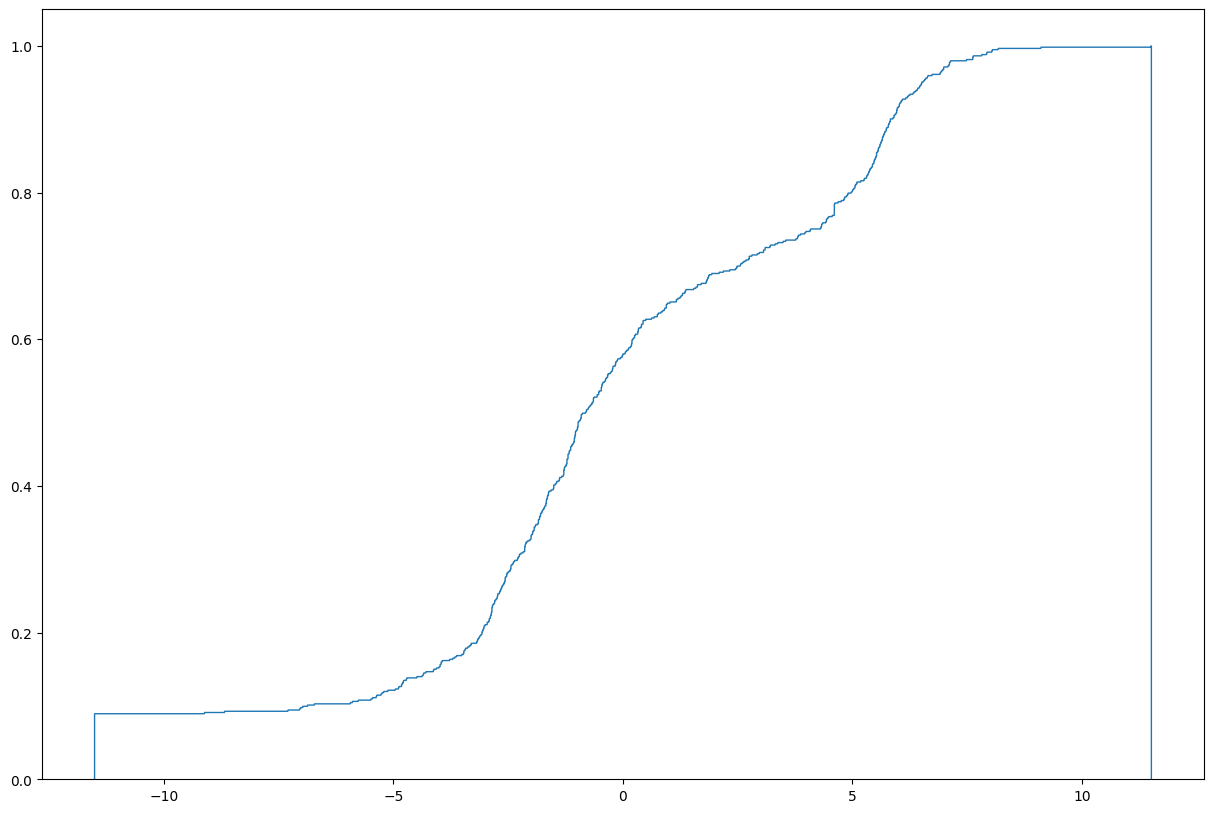

In [24]:
from models import SymbolicGaussianDiffusion, PointNetConfig

pconfig = PointNetConfig(
    embeddingSize=n_embd,
    numberofPoints=numPoints,
    numberofVars=numVars,
    numberofYs=numYs,
)
model = SymbolicGaussianDiffusion(
    tnet_config=pconfig,
    vocab_size=train_dataset.vocab_size,
    max_seq_len=blockSize,
    padding_idx=test_dataset.paddingID,
    max_num_vars=9,
    n_layer=8,
    n_head=8,
    n_embd=n_embd,
    timesteps=timesteps,
    beta_start=0.0001,
    beta_end=0.02,
    set_transformer=True,
).to(device)

model_path = "/content/3_var_set_transformer.pth"
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()
fName="/content/drive/MyDrive/Colab/STAT946_proj/results/diffusym8/ddim_step_1/3_var_set_transformer.txt"
test_results = run_and_plot(model, fName, test_loader, textTest, train_dataset, device, pconfig)